In [2]:
# import packages
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import datetime
import functions_hiwi as fct
import warnings
import xarray as xr
from matplotlib.patches import Circle
from matplotlib.patches import Rectangle

In [3]:
# set ignore warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [4]:
# set main directory
main_dir = r'C:\Users\illic\Python\data_hiwi\Emschergenossenschaft'

In [5]:
# set path to data
emscher_path = os.path.join(main_dir, r'EGLV_PWS_dataset_5min_v03.nc')

In [6]:
# read data
ds_emscher = xr.open_dataset(emscher_path)

In [7]:
# id neu setzen
id = np.arange(1, len(ds_emscher.id) + 1, 1) # oder: id = ['id_' + str(id) for id in (np.arange(1, len(ds_emscher.id) + 1, 1))]
ds_emscher['id'] = id

In [8]:
# create DataFrame
df_emscher = pd.DataFrame(data=ds_emscher.rainfall.sel(id=slice(1, 10)).values.T, index=ds_emscher.time.values ,columns=ds_emscher.id.sel(id=slice(1, 10)).values)

# create DataFrame with no NaN values
df_emscher_nonan = df_emscher.fillna(0)

In [9]:
# create DataFrame with coordinates
df_coordinaten_emscher = pd.DataFrame(data=(ds_emscher.lon.values, ds_emscher.lat.values), index=['lon', 'lat'], columns=ds_emscher.id.values).T

In [10]:
# transform coordinates to x, y

# x, y = fct.LatLon_To_XY(primary_locations_df['lon'], primary_locations_df['lat'])
# coordinates_primary_utm32 = pd.DataFrame({'lon': x, 'lat': y}, index=primary_locations_df.index)

x, y = fct.LatLon_To_XY(df_coordinaten_emscher['lon'], df_coordinaten_emscher['lat'])
coordinates_secondary_utm32 = pd.DataFrame({'lon': x, 'lat': y}, index=df_coordinaten_emscher.index)

In [35]:
def coordinates_all_stations_in_range(loc_prim, loc_sec, y, station, frame, geo, radius, ref_df):
    
    if y == 'primary':
        coords_lon = loc_prim['lon']
        coords_lat = loc_prim['lat']
    elif y == 'secondary':
        coords_lon = loc_sec['lon']
        coords_lat = loc_sec['lat']
    elif y == 'both':
        coords_lon_prim = loc_prim['lon']
        coords_lat_prim = loc_prim['lat']
        coords_lon_sec = loc_sec['lon']
        coords_lat_sec = loc_sec['lat']

    if y == 'both': # plot both networks
        name_plot = 'Coordinates ' + y + ' networks'
        plt.scatter(x=coords_lon_prim, y=coords_lat_prim, s=20, color='red', label='primary network', marker='x', linewidth=1)
        plt.scatter(x=coords_lon_sec, y=coords_lat_sec, s=2, color='blue', label='secondary network', alpha=0.5)
        plt.legend()
    else: # plot one network, primary or secondary, with selected station (primary or secondary)
        name_plot = 'Coordinates ' + y + ' network: ams' + str(station)
        plt.scatter(x=coords_lon, y=coords_lat, s=10)
        if type(station) == int:
            if y == 'primary':
                plt.scatter(loc_prim['lon'].loc[station], loc_prim['lat'].loc[station], color='red')
            elif y == 'secondary':
                plt.scatter(loc_sec['lon'].loc[station], loc_sec['lat'].loc[station], color='red')

                # plot secondary reference stations of selected station
                for station_ref in ref_df.index:
                    plt.scatter(loc_sec['lon'].loc[station_ref], loc_sec['lat'].loc[station_ref], color='lime', s=10)

    # plot circle
    if geo == 'circle':
        kreis = Circle((loc_sec['lon'].loc[station], loc_sec['lat'].loc[station]), radius=radius, color='black', linewidth=0.5, fill=False)
        plt.gca().add_patch(kreis)
    # plot rectangle
    elif geo == 'rectangle':
        quadrat = Rectangle((loc_sec['lon'].loc[station] - radius, loc_sec['lat'].loc[station] - radius), radius*2, radius*2, color='black', linewidth=0.5, fill=False)
        plt.hlines(loc_sec['lat'].loc[station], loc_sec['lon'].loc[station] - radius, loc_sec['lon'].loc[station] + radius, linewidths=0.5, color='black')
        plt.vlines(loc_sec['lon'].loc[station], loc_sec['lat'].loc[station] - radius, loc_sec['lat'].loc[station] + radius, linewidths=0.5, color='black')
        plt.gca().add_patch(quadrat) 

    plt.axis('equal')

    # set frame of view for plot
    if type(frame) == int:
        try:
            plt.xlim(loc_sec['lon'].loc[station] - frame, loc_sec['lon'].loc[station] + frame)
        except:
            if ((loc_sec['lon'].loc[station] - frame) < loc_sec['lon'].min()):
                plt.xlim(loc_sec['lon'].min(), loc_sec['lon'].loc[station] + frame)
            if ((loc_sec['lon'].loc[station] + frame) > loc_sec['lon'].max()):
                plt.xlim(loc_sec['lon'].loc[station] - frame, loc_sec['lon'].max())
        try:
            plt.ylim(loc_sec['lat'].loc[station] - frame, loc_sec['lat'].loc[station] + frame)
        except:
            if ((loc_sec['lat'].loc[station] - frame) < loc_sec['lat'].min()):
                plt.ylim(loc_sec['lat'].min(), loc_sec['lat'].loc[station] + frame)
            if ((loc_sec['lat'].loc[station] + frame) > loc_sec['lat'].max()):
                plt.ylim(loc_sec['lat'].loc[station] - frame, loc_sec['lat'].max())
    else:
        pass
    
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.title(name_plot)

    plt.show()
    plt.close()
    
    return

In [38]:
def find_all_stations_in_range(loc_prim, loc_sec, station, frame, radius, plot=True):
    coordinates = loc_sec
    # finde stationen, die innerhalb eines bestimmten Bereich um die Station liegen
    # set frame for search

    # set coordinates of the station
    lon_station = coordinates['lon'].loc[station]
    lat_station = coordinates['lat'].loc[station]

    list_reference_stations_lon = []
    list_reference_stations_lat = []
    list_station = []
    list_distance = []

    # find the 4 nearest stations in frame
    for i in coordinates.index:
        lon = coordinates['lon'].loc[i]
        lat = coordinates['lat'].loc[i]
        if (np.sqrt((lon - lon_station)**2 + (lat - lat_station)**2) <= radius):
            if lon == lon_station and lat == lat_station:
                pass
            else:
                # print('lon:', lon, 'lat:', lat, '\nstation nr.:', i)
                # print('\n')

                distance = round(np.sqrt((lon - lon_station)**2 + (lat - lat_station)**2), 2)
                
                list_distance.append(distance)
                list_station.append(i)
                list_reference_stations_lon.append(round(lon, 2))
                list_reference_stations_lat.append(round(lat, 2))
        
        array_reference_stations = np.array([list_reference_stations_lon, list_reference_stations_lat, list_distance]).T
        df_reference_stations = pd.DataFrame(array_reference_stations, columns=['lon', 'lat', 'distance'], index=list_station)

    if plot:
        coordinates_all_stations_in_range(loc_prim, loc_sec, 'secondary', station, frame, 'circle', radius, df_reference_stations)
       
    return df_reference_stations

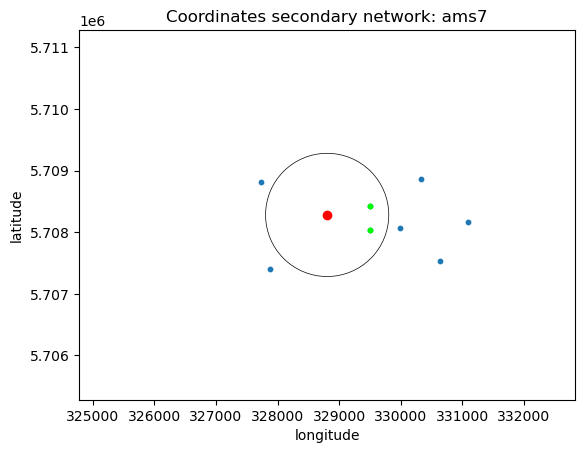

In [40]:
df_reference_stations = find_all_stations_in_range(coordinates_secondary_utm32, coordinates_secondary_utm32, 7, 3000, 1000, plot=True)

In [41]:
def berechnung_gewichte_emscher(df_reference_stations):

    list_gewichte = []

    # berechnung Teiler
    teiler = 0
    for ref_station in df_reference_stations.index:
        teiler += (1/(df_reference_stations['distance'].loc[ref_station])**2)

    # berechnung Gewichte der Referenzstationen
    for ref_station in df_reference_stations.index:
        weight = (1/(df_reference_stations['distance'].loc[ref_station])**2)/teiler
        list_gewichte.append(weight)

    df_reference_stations['weight'] = list_gewichte

    return df_reference_stations

In [47]:
df_reference_stations = berechnung_gewichte_emscher(df_reference_stations)
df_reference_stations

,lon,lat,distance,weight
8,329495.01,5708035.97,731.35,0.487115
9,329503.94,5708426.05,712.74,0.512885


In [48]:
def list_nan_sequences_schnell(data, station):
    
    '''starts, ends, len_seq'''
    
    timedelta = datetime.timedelta(minutes=5)

    is_nan = data[station].isna() # gibt true zurück, wenn Wert NaN ist
    diff = is_nan.diff() # gibt true zurück, wenn Wert zu Nan oder Nan zu Wert springt

    if is_nan[0] == True:
        diff[0] = True

    starts = diff[diff == True].index[::2]
    ends = diff[diff == True].index[1::2] - timedelta

    if is_nan[-1] == True:
        ends = ends.append(data.index[-1:])
    elif len(starts) > len(ends):
        starts = starts.delete(-1)

    len_seq = ((ends + timedelta) - starts)/timedelta
    len_seq = len_seq.astype(int)
    
    return starts, ends, len_seq

In [51]:
def get_data_nan_seq_before_peak_new(data, station, quantile):

    # get info about nan sequences and peaks
    starts, ends, len_seq = list_nan_sequences_schnell(data, station) # gives start, end and length of nan sequences
    peaks = data[station][data[station] > data[station].quantile(quantile)] # gives values + index of peak

    # check wich sequence has peak
    ends_plus_timedelta = ends + datetime.timedelta(minutes=5) # add timedelta to ends, because the peak is in the next time step
    peaks_mit_nan_seq = ends_plus_timedelta.intersection(peaks.index)

    # create mask to filter for starts of nan sequences with peaks
    mask = ends_plus_timedelta.isin(peaks_mit_nan_seq) # are the values of ends_plus_timedelta in ends_nan_seq_mit_peak, to get the place of starts of nan sequences with peaks
    starts_nan_seq_mit_peak = starts[mask]

    return starts_nan_seq_mit_peak, peaks_mit_nan_seq  

In [52]:
def berechnung_referenzniederschlag_emscher(df_reference_stations, data, data_nonan, station_zahl):
    
    # df zum speichern der Referenzniederschläge erstellen
    df_reference_values = data[[station_zahl]].copy()

    # abrufen der Informationen über NaN-Sequenz und Peaks
    starts_nan_seq_mit_peak, peaks_mit_nan_seq = get_data_nan_seq_before_peak_new(data, station_zahl, 0.99)

    # berechnung Referenzniederschlag
    # für jede NaN-Sequenz und Peak
    for c, p in zip(range(0, len(starts_nan_seq_mit_peak)), range(0, len(peaks_mit_nan_seq))):
        # für jeden Index in der NaN-Sequenz
        for index in data_nonan.loc[starts_nan_seq_mit_peak[c] : peaks_mit_nan_seq[p]].index:
            h_ref = 0
            # für jede Referenzstation
            for ref_station in df_reference_stations.index:
                h_ref += data_nonan[ref_station].loc[index] * df_reference_stations['weight'].loc[ref_station]

            # speichern des Referenzniederschlags für den Index
            df_reference_values.loc[index] = h_ref

        # alle Werte außerhalb der NaN-Sequenz und Peaks auf NaN setzen
        if c == 0 and p == 0:
            df_reference_values.loc[(df_reference_values.index[0]) : (starts_nan_seq_mit_peak[c] - datetime.timedelta(minutes=5))] = np.nan
        if (c > 0 and p > 0) and ((c < len(starts_nan_seq_mit_peak) - 1) and (p < len(peaks_mit_nan_seq) - 1)):
            df_reference_values.loc[(peaks_mit_nan_seq[p - 1] + datetime.timedelta(minutes=5)) : (starts_nan_seq_mit_peak[c] - datetime.timedelta(minutes=5))] = np.nan
        if (c == len(starts_nan_seq_mit_peak) - 1) and (p == len(peaks_mit_nan_seq) - 1):
            df_reference_values.loc[(peaks_mit_nan_seq[p] + datetime.timedelta(minutes=5)) : (df_reference_values.index[-1])] = np.nan
    
    return df_reference_values

In [54]:
df_reference_values = berechnung_referenzniederschlag_emscher(df_reference_stations, df_emscher, df_emscher_nonan, 7)
df_reference_values

,7
2014-04-26 16:30:00,NaN
2014-04-26 16:35:00,NaN
2014-04-26 16:40:00,NaN
2014-04-26 16:45:00,NaN
2014-04-26 16:50:00,NaN
...,...
2024-01-10 23:35:00,NaN
2024-01-10 23:40:00,NaN
2024-01-10 23:45:00,NaN
2024-01-10 23:50:00,NaN


In [ ]:
starts_nan_seq_mit_peak, peaks_mit_nan_seq 

In [56]:
def correct_data_new_emscher(data, reference_df, station_zahl, quantile, correct_peak=True, correct_1_2=True, correct_0_pres_ref=True):

    # nans vor peaks korrigieren
    if correct_peak:

        starts_nan_seq_mit_peak, peaks_mit_nan_seq = get_data_nan_seq_before_peak_new(data, station_zahl, quantile)
    
        data_corrected = data[[station_zahl]].copy() # copy the data to a new dataframe

        frequency = '5min'

        for i in range(len(peaks_mit_nan_seq)):

            datetime_index = pd.date_range(start=starts_nan_seq_mit_peak[i], end=peaks_mit_nan_seq[i], freq=frequency) # create a datetime index for the time period of the nan sequence before the peak
            sum = reference_df[station_zahl].loc[starts_nan_seq_mit_peak[i] : peaks_mit_nan_seq[i]].sum() # sum of the reference values for the time period of the nan sequence before the peak
            value_peak = data[station_zahl].loc[peaks_mit_nan_seq[i]] # value of the peak

            for index in datetime_index:
                try:
                    peak_portion = round(((reference_df[station_zahl].loc[index] / sum) * value_peak), 2)
                except ZeroDivisionError:
                    peak_portion = 0
                    
                data_corrected[station_zahl].loc[index] = peak_portion # replace the nan values with the calculated peak portion
            
    # 1er und 2er nan sequenzen korrigieren
    if correct_1_2:

        data_corrected = fct.einer_zweier_sequ_korrigieren(data_corrected, station_zahl, True, True)

    # nan sequenzen korrigieren, die mit 0 anfnagen und enden und bei denen die summe des niederschlag im referenz df 0 ist
    if correct_0_pres_ref:

        starts, ends, nan_sequs = fct.list_nan_sequences_schnell(data_corrected, station_zahl, frequency)

        list = []

        # erste und letzte nan sequenz extra kontrollieren
        sum = reference_df[station_zahl].loc[starts[0] : ends[0]].values.sum()
        if sum == 0:
            list.append(0)
        sum = reference_df[station_zahl].loc[starts[-1] : ends[-1]].values.sum()
        if sum == 0:
            list.append(-1)

        for i in range(len(starts)):
            try:
                if ((data_corrected.loc[starts[i] - datetime.timedelta(minutes=5)]) == 0).bool() and ((data_corrected.loc[ends[i] + datetime.timedelta(minutes=5)]) == 0).bool():
                    sum = reference_df[station_zahl].loc[starts[i] : ends[i]].values.sum()
                    if sum == 0:
                        list.append(i)
            except KeyError:
                continue
            
        for i in list:
            data_corrected.loc[starts[i] : ends[i]] = 0

    return data_corrected